In [55]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

from tqdm import tqdm

In [58]:
def feature_extraction(file_name):
    features = []
    audio, sample_rate = librosa.load(file_name)
    
    # mfcc
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    features.extend(np.mean(mfcc, axis=1))
    features.extend(np.std(mfcc, axis=1))

    # spectral_centroids
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
    features.extend([np.mean(spectral_centroids), np.std(spectral_centroids)])

    # zero crossin rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    features.extend([np.mean(zero_crossing_rate), np.std(zero_crossing_rate)])
    
    # Rms Energy
    rms_energy = librosa.feature.rms(y=audio)[0]
    features.extend([np.mean(rms_energy), np.std(rms_energy)])

    # spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)[0]
    features.extend([np.mean(spectral_bandwidth), np.std(spectral_bandwidth)])

    # spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    features.extend(np.mean(spectral_contrast, axis=1))

    # Onset Strength
    onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
    features.extend([np.mean(onset_env), np.std(onset_env)])

    return np.array(features)

In [59]:
df = pd.read_csv('meta.csv')
dataset_path = 'public_dataset/'

df = df[:8000] # Taking only 8k audio files

extracted_features = []

for index_num, row in tqdm(df.iterrows()):
   file_name = dataset_path + row['uuid'] + '.wav'
   labels = row['classID']
   data = feature_extraction(file_name)
   extracted_features.append([data, labels])

extracted_features = pd.DataFrame(extracted_features, columns=['Feature', 'Class'])
print(extracted_features)

8000it [15:24,  8.66it/s]

                                                Feature  Class
0     [-620.25830078125, 61.49414825439453, -15.2883...    0.0
1     [-563.337890625, 18.238452911376953, -2.340278...    1.0
2     [-736.4028930664062, 55.81863784790039, 9.0535...    0.0
3     [-278.8795471191406, 100.88816833496094, -25.8...    1.0
4     [-1131.37109375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    0.0
...                                                 ...    ...
7995  [-413.213134765625, 46.74795150756836, -24.516...    0.0
7996  [-306.65972900390625, 108.84735870361328, -32....    0.0
7997  [-460.4200744628906, 44.10028076171875, -8.913...    1.0
7998  [-433.1278991699219, 35.6968879699707, -21.607...    1.0
7999  [-345.0193176269531, 81.45926666259766, -9.335...    0.0

[8000 rows x 2 columns]


In [71]:
extracted_features.to_pickle('advanced_extraction.pkl')

In [75]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM, MaxPooling1D

In [73]:

# Assume X is your feature array and y is your labels
X = np.array(extracted_features['Feature'].to_list())
y = np.array(extracted_features['Class'].to_list())

X.shape, y.shape

((8000, 43), (8000,))

In [76]:
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    MaxPooling1D(2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 41, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 20, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 128)           24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 9, 128)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 9, 64)             49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)               

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=27)

In [80]:
%%capture --no-stdout
import tensorflow_addons as tfa
# ADDRESS IMBALANCE:
from sklearn.utils.class_weight import compute_class_weight

In [81]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.9495548961424333, 1: 1.056105610561056}

In [82]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, class_weight=class_weight_dict, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[tqdm_callback])

Training:   0%|                                        0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/200                                                                 ETA: ?s - 

Epoch 1/100
200/200 [==============================] - 4s 12ms/step - loss: 0.1586 - accuracy: 0.9361 - val_loss: 0.5616 - val_accuracy: 0.8419
Epoch 2/100


0/200                                                                 ETA: ?s - 

Epoch 2/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1609 - accuracy: 0.9312 - val_loss: 0.6276 - val_accuracy: 0.8250
Epoch 3/100


0/200                                                                 ETA: ?s - 

Epoch 3/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1619 - accuracy: 0.9312 - val_loss: 0.5439 - val_accuracy: 0.8375
Epoch 4/100


0/200                                                                 ETA: ?s - 

Epoch 4/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1568 - accuracy: 0.9300 - val_loss: 0.5911 - val_accuracy: 0.8225
Epoch 5/100


0/200                                                                 ETA: ?s - 

Epoch 5/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1457 - accuracy: 0.9336 - val_loss: 0.6006 - val_accuracy: 0.8363
Epoch 6/100


0/200                                                                 ETA: ?s - 

Epoch 6/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1442 - accuracy: 0.9398 - val_loss: 0.6239 - val_accuracy: 0.8356
Epoch 7/100


0/200                                                                 ETA: ?s - 

Epoch 7/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1363 - accuracy: 0.9427 - val_loss: 0.6740 - val_accuracy: 0.8338
Epoch 8/100


0/200                                                                 ETA: ?s - 

Epoch 8/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1491 - accuracy: 0.9380 - val_loss: 0.6252 - val_accuracy: 0.8356
Epoch 9/100


0/200                                                                 ETA: ?s - 

Epoch 9/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1405 - accuracy: 0.9434 - val_loss: 0.5128 - val_accuracy: 0.8425
Epoch 10/100


0/200                                                                 ETA: ?s - 

Epoch 10/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1278 - accuracy: 0.9456 - val_loss: 0.6841 - val_accuracy: 0.7713
Epoch 11/100


0/200                                                                 ETA: ?s - 

Epoch 11/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1360 - accuracy: 0.9417 - val_loss: 0.6249 - val_accuracy: 0.8456
Epoch 12/100


0/200                                                                 ETA: ?s - 

Epoch 12/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1263 - accuracy: 0.9444 - val_loss: 0.5733 - val_accuracy: 0.8263
Epoch 13/100


0/200                                                                 ETA: ?s - 

Epoch 13/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1280 - accuracy: 0.9433 - val_loss: 0.6086 - val_accuracy: 0.8150
Epoch 14/100


0/200                                                                 ETA: ?s - 

Epoch 14/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1358 - accuracy: 0.9439 - val_loss: 0.6182 - val_accuracy: 0.8281
Epoch 15/100


0/200                                                                 ETA: ?s - 

Epoch 15/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1171 - accuracy: 0.9517 - val_loss: 0.6224 - val_accuracy: 0.8363
Epoch 16/100


0/200                                                                 ETA: ?s - 

Epoch 16/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1164 - accuracy: 0.9516 - val_loss: 0.6504 - val_accuracy: 0.8244
Epoch 17/100


0/200                                                                 ETA: ?s - 

Epoch 17/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1178 - accuracy: 0.9508 - val_loss: 0.6598 - val_accuracy: 0.8375
Epoch 18/100


0/200                                                                 ETA: ?s - 

Epoch 18/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1050 - accuracy: 0.9567 - val_loss: 0.6261 - val_accuracy: 0.8275
Epoch 19/100


0/200                                                                 ETA: ?s - 

Epoch 19/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1138 - accuracy: 0.9533 - val_loss: 0.6670 - val_accuracy: 0.8231
Epoch 20/100


0/200                                                                 ETA: ?s - 

Epoch 20/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1152 - accuracy: 0.9520 - val_loss: 0.6524 - val_accuracy: 0.8356
Epoch 21/100


0/200                                                                 ETA: ?s - 

Epoch 21/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1066 - accuracy: 0.9569 - val_loss: 0.7221 - val_accuracy: 0.8363
Epoch 22/100


0/200                                                                 ETA: ?s - 

Epoch 22/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0968 - accuracy: 0.9602 - val_loss: 0.6146 - val_accuracy: 0.8269
Epoch 23/100


0/200                                                                 ETA: ?s - 

Epoch 23/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0978 - accuracy: 0.9611 - val_loss: 0.5989 - val_accuracy: 0.8331
Epoch 24/100


0/200                                                                 ETA: ?s - 

Epoch 24/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0868 - accuracy: 0.9648 - val_loss: 0.6352 - val_accuracy: 0.8369
Epoch 25/100


0/200                                                                 ETA: ?s - 

Epoch 25/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1088 - accuracy: 0.9541 - val_loss: 0.6809 - val_accuracy: 0.8163
Epoch 26/100


0/200                                                                 ETA: ?s - 

Epoch 26/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0953 - accuracy: 0.9609 - val_loss: 0.7672 - val_accuracy: 0.8394
Epoch 27/100


0/200                                                                 ETA: ?s - 

Epoch 27/100
200/200 [==============================] - 2s 11ms/step - loss: 0.1027 - accuracy: 0.9570 - val_loss: 0.6364 - val_accuracy: 0.8331
Epoch 28/100


0/200                                                                 ETA: ?s - 

Epoch 28/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0877 - accuracy: 0.9653 - val_loss: 0.6977 - val_accuracy: 0.8338
Epoch 29/100


0/200                                                                 ETA: ?s - 

Epoch 29/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0927 - accuracy: 0.9652 - val_loss: 0.7912 - val_accuracy: 0.8344
Epoch 30/100


0/200                                                                 ETA: ?s - 

Epoch 30/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0928 - accuracy: 0.9639 - val_loss: 0.7789 - val_accuracy: 0.8225
Epoch 31/100


0/200                                                                 ETA: ?s - 

Epoch 31/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0844 - accuracy: 0.9667 - val_loss: 0.7421 - val_accuracy: 0.8306
Epoch 32/100


0/200                                                                 ETA: ?s - 

Epoch 32/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0867 - accuracy: 0.9661 - val_loss: 0.7808 - val_accuracy: 0.8306
Epoch 33/100


0/200                                                                 ETA: ?s - 

Epoch 33/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1017 - accuracy: 0.9598 - val_loss: 0.6193 - val_accuracy: 0.8206
Epoch 34/100


0/200                                                                 ETA: ?s - 

Epoch 34/100
200/200 [==============================] - 2s 10ms/step - loss: 0.1018 - accuracy: 0.9583 - val_loss: 0.6186 - val_accuracy: 0.8275
Epoch 35/100


0/200                                                                 ETA: ?s - 

Epoch 35/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0783 - accuracy: 0.9695 - val_loss: 0.7901 - val_accuracy: 0.8319
Epoch 36/100


0/200                                                                 ETA: ?s - 

Epoch 36/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0847 - accuracy: 0.9686 - val_loss: 0.8183 - val_accuracy: 0.8250
Epoch 37/100


0/200                                                                 ETA: ?s - 

Epoch 37/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0702 - accuracy: 0.9725 - val_loss: 0.8096 - val_accuracy: 0.8194
Epoch 38/100


0/200                                                                 ETA: ?s - 

Epoch 38/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0681 - accuracy: 0.9734 - val_loss: 0.9366 - val_accuracy: 0.8138
Epoch 39/100


0/200                                                                 ETA: ?s - 

Epoch 39/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0882 - accuracy: 0.9667 - val_loss: 0.7302 - val_accuracy: 0.8156
Epoch 40/100


0/200                                                                 ETA: ?s - 

Epoch 40/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0791 - accuracy: 0.9708 - val_loss: 0.6325 - val_accuracy: 0.8300
Epoch 41/100


0/200                                                                 ETA: ?s - 

Epoch 41/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0784 - accuracy: 0.9688 - val_loss: 0.7448 - val_accuracy: 0.8331
Epoch 42/100


0/200                                                                 ETA: ?s - 

Epoch 42/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0598 - accuracy: 0.9759 - val_loss: 0.8262 - val_accuracy: 0.8188
Epoch 43/100


0/200                                                                 ETA: ?s - 

Epoch 43/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0752 - accuracy: 0.9692 - val_loss: 0.8503 - val_accuracy: 0.8219
Epoch 44/100


0/200                                                                 ETA: ?s - 

Epoch 44/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0787 - accuracy: 0.9692 - val_loss: 0.7754 - val_accuracy: 0.8325
Epoch 45/100


0/200                                                                 ETA: ?s - 

Epoch 45/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0646 - accuracy: 0.9741 - val_loss: 0.7046 - val_accuracy: 0.8188
Epoch 46/100


0/200                                                                 ETA: ?s - 

Epoch 46/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0691 - accuracy: 0.9744 - val_loss: 0.7171 - val_accuracy: 0.8325
Epoch 47/100


0/200                                                                 ETA: ?s - 

Epoch 47/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0634 - accuracy: 0.9780 - val_loss: 0.7216 - val_accuracy: 0.8294
Epoch 48/100


0/200                                                                 ETA: ?s - 

Epoch 48/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0533 - accuracy: 0.9812 - val_loss: 0.8328 - val_accuracy: 0.8256
Epoch 49/100


0/200                                                                 ETA: ?s - 

Epoch 49/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0675 - accuracy: 0.9772 - val_loss: 0.7871 - val_accuracy: 0.8169
Epoch 50/100


0/200                                                                 ETA: ?s - 

Epoch 50/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0648 - accuracy: 0.9737 - val_loss: 0.7832 - val_accuracy: 0.8138
Epoch 51/100


0/200                                                                 ETA: ?s - 

Epoch 51/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0684 - accuracy: 0.9758 - val_loss: 0.8779 - val_accuracy: 0.8256
Epoch 52/100


0/200                                                                 ETA: ?s - 

Epoch 52/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0584 - accuracy: 0.9781 - val_loss: 0.7548 - val_accuracy: 0.8294
Epoch 53/100


0/200                                                                 ETA: ?s - 

Epoch 53/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0600 - accuracy: 0.9767 - val_loss: 0.9163 - val_accuracy: 0.8263
Epoch 54/100


0/200                                                                 ETA: ?s - 

Epoch 54/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0538 - accuracy: 0.9794 - val_loss: 0.9142 - val_accuracy: 0.8275
Epoch 55/100


0/200                                                                 ETA: ?s - 

Epoch 55/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0566 - accuracy: 0.9808 - val_loss: 0.8328 - val_accuracy: 0.8194
Epoch 56/100


0/200                                                                 ETA: ?s - 

Epoch 56/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0659 - accuracy: 0.9753 - val_loss: 0.8926 - val_accuracy: 0.8213
Epoch 57/100


0/200                                                                 ETA: ?s - 

Epoch 57/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0520 - accuracy: 0.9820 - val_loss: 0.9733 - val_accuracy: 0.8238
Epoch 58/100


0/200                                                                 ETA: ?s - 

Epoch 58/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0508 - accuracy: 0.9806 - val_loss: 0.9539 - val_accuracy: 0.8188
Epoch 59/100


0/200                                                                 ETA: ?s - 

Epoch 59/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0439 - accuracy: 0.9837 - val_loss: 0.8748 - val_accuracy: 0.8075
Epoch 60/100


0/200                                                                 ETA: ?s - 

Epoch 60/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0759 - accuracy: 0.9698 - val_loss: 0.8311 - val_accuracy: 0.8175
Epoch 61/100


0/200                                                                 ETA: ?s - 

Epoch 61/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0747 - accuracy: 0.9723 - val_loss: 0.7274 - val_accuracy: 0.8275
Epoch 62/100


0/200                                                                 ETA: ?s - 

Epoch 62/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0538 - accuracy: 0.9797 - val_loss: 0.8973 - val_accuracy: 0.8206
Epoch 63/100


0/200                                                                 ETA: ?s - 

Epoch 63/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0627 - accuracy: 0.9798 - val_loss: 0.8767 - val_accuracy: 0.8288
Epoch 64/100


0/200                                                                 ETA: ?s - 

Epoch 64/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0491 - accuracy: 0.9822 - val_loss: 0.7888 - val_accuracy: 0.8338
Epoch 65/100


0/200                                                                 ETA: ?s - 

Epoch 65/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0488 - accuracy: 0.9812 - val_loss: 0.9109 - val_accuracy: 0.8331
Epoch 66/100


0/200                                                                 ETA: ?s - 

Epoch 66/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0588 - accuracy: 0.9778 - val_loss: 0.8520 - val_accuracy: 0.8275
Epoch 67/100


0/200                                                                 ETA: ?s - 

Epoch 67/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0608 - accuracy: 0.9762 - val_loss: 0.7091 - val_accuracy: 0.8156
Epoch 68/100


0/200                                                                 ETA: ?s - 

Epoch 68/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0408 - accuracy: 0.9855 - val_loss: 0.9430 - val_accuracy: 0.8213
Epoch 69/100


0/200                                                                 ETA: ?s - 

Epoch 69/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0583 - accuracy: 0.9811 - val_loss: 0.8121 - val_accuracy: 0.8331
Epoch 70/100


0/200                                                                 ETA: ?s - 

Epoch 70/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0420 - accuracy: 0.9862 - val_loss: 0.9302 - val_accuracy: 0.8325
Epoch 71/100


0/200                                                                 ETA: ?s - 

Epoch 71/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0849 - accuracy: 0.9684 - val_loss: 0.7603 - val_accuracy: 0.8331
Epoch 72/100


0/200                                                                 ETA: ?s - 

Epoch 72/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0589 - accuracy: 0.9787 - val_loss: 0.8556 - val_accuracy: 0.8269
Epoch 73/100


0/200                                                                 ETA: ?s - 

Epoch 73/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0361 - accuracy: 0.9867 - val_loss: 0.9577 - val_accuracy: 0.8188
Epoch 74/100


0/200                                                                 ETA: ?s - 

Epoch 74/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0545 - accuracy: 0.9811 - val_loss: 0.9442 - val_accuracy: 0.8263
Epoch 75/100


0/200                                                                 ETA: ?s - 

Epoch 75/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0540 - accuracy: 0.9786 - val_loss: 0.8016 - val_accuracy: 0.8256
Epoch 76/100


0/200                                                                 ETA: ?s - 

Epoch 76/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0501 - accuracy: 0.9822 - val_loss: 0.8135 - val_accuracy: 0.8381
Epoch 77/100


0/200                                                                 ETA: ?s - 

Epoch 77/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0433 - accuracy: 0.9845 - val_loss: 0.9422 - val_accuracy: 0.8244
Epoch 78/100


0/200                                                                 ETA: ?s - 

Epoch 78/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0438 - accuracy: 0.9853 - val_loss: 0.9161 - val_accuracy: 0.8269
Epoch 79/100


0/200                                                                 ETA: ?s - 

Epoch 79/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0408 - accuracy: 0.9867 - val_loss: 0.9874 - val_accuracy: 0.8269
Epoch 80/100


0/200                                                                 ETA: ?s - 

Epoch 80/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0460 - accuracy: 0.9831 - val_loss: 0.7994 - val_accuracy: 0.8281
Epoch 81/100


0/200                                                                 ETA: ?s - 

Epoch 81/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0307 - accuracy: 0.9894 - val_loss: 1.0310 - val_accuracy: 0.8294
Epoch 82/100


0/200                                                                 ETA: ?s - 

Epoch 82/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0476 - accuracy: 0.9841 - val_loss: 0.8767 - val_accuracy: 0.8219
Epoch 83/100


0/200                                                                 ETA: ?s - 

Epoch 83/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0474 - accuracy: 0.9811 - val_loss: 0.8146 - val_accuracy: 0.8206
Epoch 84/100


0/200                                                                 ETA: ?s - 

Epoch 84/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0385 - accuracy: 0.9862 - val_loss: 0.8320 - val_accuracy: 0.8156
Epoch 85/100


0/200                                                                 ETA: ?s - 

Epoch 85/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0410 - accuracy: 0.9842 - val_loss: 0.9892 - val_accuracy: 0.8275
Epoch 86/100


0/200                                                                 ETA: ?s - 

Epoch 86/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0479 - accuracy: 0.9825 - val_loss: 0.8635 - val_accuracy: 0.8156
Epoch 87/100


0/200                                                                 ETA: ?s - 

Epoch 87/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0399 - accuracy: 0.9853 - val_loss: 0.9164 - val_accuracy: 0.8319
Epoch 88/100


0/200                                                                 ETA: ?s - 

Epoch 88/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0764 - accuracy: 0.9733 - val_loss: 0.8125 - val_accuracy: 0.8156
Epoch 89/100


0/200                                                                 ETA: ?s - 

Epoch 89/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0402 - accuracy: 0.9847 - val_loss: 0.9706 - val_accuracy: 0.8169
Epoch 90/100


0/200                                                                 ETA: ?s - 

Epoch 90/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0449 - accuracy: 0.9847 - val_loss: 1.0216 - val_accuracy: 0.8275
Epoch 91/100


0/200                                                                 ETA: ?s - 

Epoch 91/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0334 - accuracy: 0.9895 - val_loss: 1.1219 - val_accuracy: 0.8144
Epoch 92/100


0/200                                                                 ETA: ?s - 

Epoch 92/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0497 - accuracy: 0.9859 - val_loss: 1.0517 - val_accuracy: 0.8081
Epoch 93/100


0/200                                                                 ETA: ?s - 

Epoch 93/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0426 - accuracy: 0.9864 - val_loss: 0.7780 - val_accuracy: 0.8231
Epoch 94/100


0/200                                                                 ETA: ?s - 

Epoch 94/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0653 - accuracy: 0.9767 - val_loss: 0.8913 - val_accuracy: 0.8219
Epoch 95/100


0/200                                                                 ETA: ?s - 

Epoch 95/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0860 - accuracy: 0.9719 - val_loss: 0.5075 - val_accuracy: 0.8012
Epoch 96/100


0/200                                                                 ETA: ?s - 

Epoch 96/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0766 - accuracy: 0.9709 - val_loss: 0.7517 - val_accuracy: 0.8125
Epoch 97/100


0/200                                                                 ETA: ?s - 

Epoch 97/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0491 - accuracy: 0.9827 - val_loss: 0.8705 - val_accuracy: 0.8169
Epoch 98/100


0/200                                                                 ETA: ?s - 

Epoch 98/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0649 - accuracy: 0.9747 - val_loss: 0.7005 - val_accuracy: 0.8294
Epoch 99/100


0/200                                                                 ETA: ?s - 

Epoch 99/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0402 - accuracy: 0.9866 - val_loss: 0.9528 - val_accuracy: 0.8213
Epoch 100/100


0/200                                                                 ETA: ?s - 

Epoch 100/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0395 - accuracy: 0.9866 - val_loss: 0.9008 - val_accuracy: 0.8175


In [83]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)

50/50 [==============================] - 0s 3ms/step - loss: 0.9008 - accuracy: 0.8175
0.8174999952316284


In [84]:
test_features = []

for file in os.listdir('./test_samples/'):
    if (file == '.DS_Store'):
        continue
    mfcc = feature_extraction(f"./test_samples/{file}")
    test_features.append(mfcc)

test_features = np.array(test_features)

In [39]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [91]:
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [96]:
prediction = model.predict(X_test)
prediction_reshaped = []

for i in prediction:
    prediction_reshaped.append(i[0])

prediction_reshaped

50/50 [==============================] - 0s 3ms/step


[0.99997723,
 0.99993396,
 1.0,
 0.9880284,
 6.057065e-08,
 4.0232482e-08,
 0.9995788,
 0.9546662,
 0.9999979,
 0.0029446697,
 0.9999959,
 0.9999375,
 0.9999395,
 6.437844e-08,
 0.00029312595,
 0.9994912,
 0.117096834,
 1.0496207e-05,
 8.178859e-08,
 1.1341443e-07,
 0.9999956,
 0.14468953,
 3.4131492e-07,
 0.9999999,
 0.9839552,
 0.9971546,
 0.00017740532,
 2.519672e-09,
 0.99975413,
 1.5060104e-06,
 0.53570986,
 0.006123704,
 0.99956053,
 0.9999991,
 0.9999992,
 0.9999495,
 0.0020084595,
 0.9997253,
 0.9999882,
 0.999996,
 0.9999996,
 0.3732161,
 0.023255238,
 0.9999147,
 3.9997954e-05,
 0.99999464,
 0.8249351,
 0.9990951,
 0.0014230052,
 0.1927471,
 0.99999744,
 3.359313e-08,
 0.99543554,
 0.9099964,
 4.6369537e-06,
 1.7902739e-08,
 6.8547735e-05,
 7.404714e-08,
 0.80148834,
 0.1260616,
 0.99961656,
 0.0062975814,
 0.9999997,
 0.00074215635,
 0.99778247,
 0.97196066,
 0.95634735,
 0.99982554,
 0.6373055,
 0.99999994,
 5.2890603e-10,
 0.003741485,
 0.08393819,
 0.0005402042,
 0.000740

In [107]:
pred = []

for i in prediction_reshaped:
    if i >= 0.90:
        pred.append(1)
    else:
        pred.append(0)

pred = np.array(pred)

In [108]:
y_test.shape

(1600,)

In [109]:
pred.shape

(1600,)

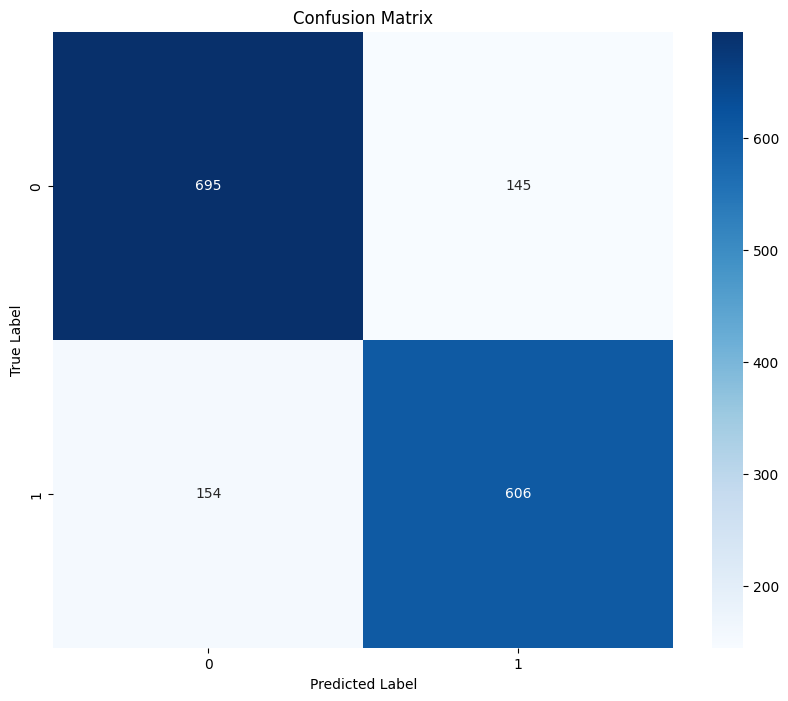

In [110]:
plot_confusion_matrix(y_test, pred)

50/50 [==============================] - 0s 3ms/step


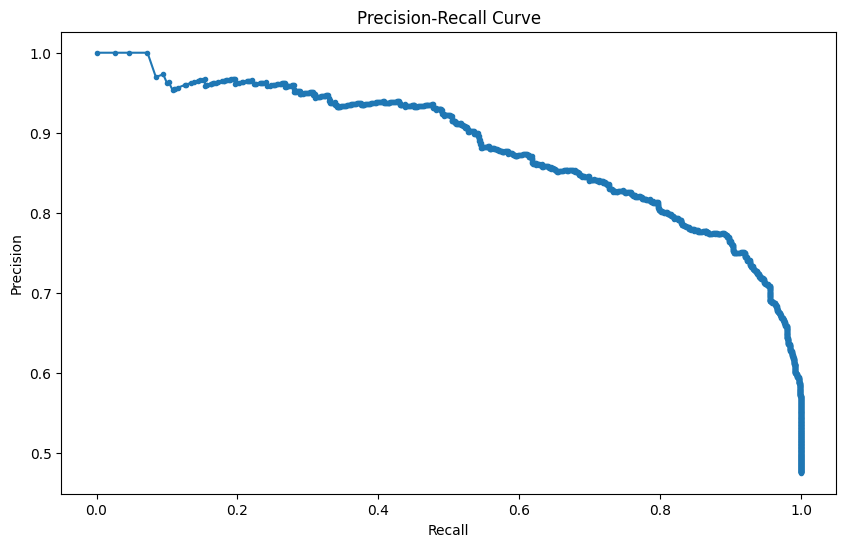

Best threshold: 0.37321609258651733


In [111]:
from sklearn.metrics import precision_recall_curve

# Assuming you have predictions from your model
y_scores = model.predict(X_test)

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best threshold: {best_threshold}")

# Use this threshold for classification
y_pred = (y_scores >= best_threshold).astype(int)

## TESTING

In [121]:
df_test = pd.read_csv('meta.csv')
df_test = df_test[-10:]

In [122]:
df_test

,uuid,cough_detected,classID
27540,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,0.9485,1.0
27541,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,0.5591,0.0
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,1.0000,1.0
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,0.9784,1.0
27544,fff13fa2-a725-49ef-812a-39c6cedda33d,0.7154,0.0
27545,fff30afc-db62-4408-a585-07ca9a254fcc,0.9698,1.0
27546,fff3ff61-2387-4139-938b-539db01e6be5,0.5257,0.0
27547,fff474bf-39a4-4a61-8348-6b992fb5e439,0.1945,0.0
27548,fffaa9f8-4db0-46c5-90fb-93b7b014b55d,0.0243,0.0
27549,fffce9f0-a5e8-4bee-b13b-c671aac4a61c,0.9754,1.0


In [124]:
label = df_test.classID
label = np.array(label)
label

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1.])

In [126]:
extracted_test_features = []

for index_num, row in tqdm(df_test.iterrows()):
    file_name = dataset_path + row['uuid'] + '.wav'
    data = feature_extraction(file_name)
    extracted_test_features.append(data)

extracted_test_features



0it [00:00, ?it/s]

1it [00:00,  6.00it/s]

2it [00:00,  7.50it/s]

3it [00:00,  6.78it/s]

4it [00:00,  6.40it/s]

5it [00:00,  5.95it/s]

6it [00:00,  5.75it/s]

7it [00:01,  6.10it/s]

8it [00:01,  4.39it/s]

10it [00:01,  5.45it/s][A


[array([-4.77452209e+02,  5.04670677e+01, -2.13637428e+01,  5.64265251e+00,
        -8.29525661e+00,  5.72626114e+00, -1.07531414e+01, -4.68582344e+00,
        -1.12056923e+01, -4.09742069e+00, -5.59012842e+00, -6.83215189e+00,
        -1.66376397e-01,  1.55312408e+02,  6.93939285e+01,  4.12246284e+01,
         2.98596382e+01,  2.39318790e+01,  2.32477093e+01,  1.95685463e+01,
         1.47643747e+01,  1.60943165e+01,  1.14464674e+01,  1.10650816e+01,
         1.19051418e+01,  1.14064369e+01,  2.31045145e+03,  1.05082062e+03,
         1.88939686e-01,  1.11544588e-01,  2.69978605e-02,  4.87804189e-02,
         1.80176382e+03,  6.08946370e+02,  1.55329643e+01,  1.29255328e+01,
         1.47590599e+01,  1.62022438e+01,  1.75619858e+01,  1.99117367e+01,
         4.67721070e+01,  1.30443561e+00,  2.63764739e+00]),
 array([-2.75194519e+02,  9.33919678e+01,  5.36654890e-01, -1.64697990e+01,
        -4.76864529e+00,  4.81999731e+00,  8.58631790e-01, -4.08536816e+00,
        -4.32633877e+00,  3

In [131]:
extracted_test_features = np.array(extracted_test_features)
extracted_test_features_reshaped = extracted_test_features.reshape(extracted_test_features.shape[0], extracted_test_features.shape[1], 1)

In [133]:
test_prediction = model.predict(np.array(extracted_test_features_reshaped))
test_pred = (test_prediction >= best_threshold).astype(int)
test_pred

1/1 [==============================] - 0s 27ms/step


array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1]])

In [145]:
test_prediction_reshaped = test_prediction.reshape(test_prediction.shape[0])
test_prediction_reshaped

array([2.7850115e-01, 7.9431502e-06, 2.4840038e-02, 8.4334517e-01,
       9.9993867e-01, 3.4401623e-05, 2.7864147e-02, 2.2081025e-05,
       1.2695359e-05, 9.9999541e-01], dtype=float32)

In [148]:
d = {'Model' : test_prediction_reshaped,'label' : label}
d = pd.DataFrame(data=d)
d

,Model,label
0,0.278501,1.0
1,0.000008,0.0
2,0.024840,1.0
3,0.843345,1.0
4,0.999939,0.0
5,0.000034,1.0
6,0.027864,0.0
7,0.000022,0.0
8,0.000013,0.0
9,0.999995,1.0


In [149]:
test_loss, test_accuracy = model.evaluate(extracted_test_features_reshaped, label)

1/1 [==============================] - 1s 513ms/step - loss: 2.5149 - accuracy: 0.6000


In [150]:
test_accuracy

0.6000000238418579